In [3]:
import pandas as pd
import numpy as np

In [13]:
train = pd.read_csv('train.csv')
testA = pd.read_csv('testA.csv')

In [14]:
train['sample'] = 'train'
testA['sample'] = 'test'
data = pd.concat([train, testA], axis=0, ignore_index=True)

In [15]:
data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
data['employmentLength'].replace('< 1 year', '0 years', inplace=True)

def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [16]:
data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [17]:
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 298101
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 935
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 47903
policyCode 类型数： 1


In [24]:
numerical_fea = list(data.select_dtypes(exclude=['object']).columns)
data[numerical_fea] = data[numerical_fea].fillna(data[numerical_fea].median())

In [26]:
data.isnull().sum()

id                    0
loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
issueDate             0
isDefault             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9              

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [29]:
# 类型数在2之上，又不是高维稀疏的
data = pd.get_dummies(data, columns=['grade', 'subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [30]:
# 高维类别特征需要进行转换
for f in ['employmentTitle', 'postCode', 'title']:
    data[f+'_cnts'] = data.groupby([f])['id'].transform('count')
    data[f+'_rank'] = data.groupby([f])['id'].rank(ascending=False).astype(int)
    del data[f]

In [31]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
x_train = data.loc[data['sample']=='train', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
x_test = data.loc[data['sample']=='test', :].drop(['id','issueDate','isDefault', 'sample'], axis=1)
y_train = data.loc[data['sample']=='train', 'isDefault']

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [33]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')
 
vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)])
vclf = vclf .fit(x_train,y_train)
print(vclf .predict(x_test))

C:\Users\shepherd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

### 5.4.3 Stacking

Accuracy: 0.91 (+/- 0.07) [KNN]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [Naive Bayes]
Accuracy: 0.94 (+/- 0.04) [Stacking Classifier]


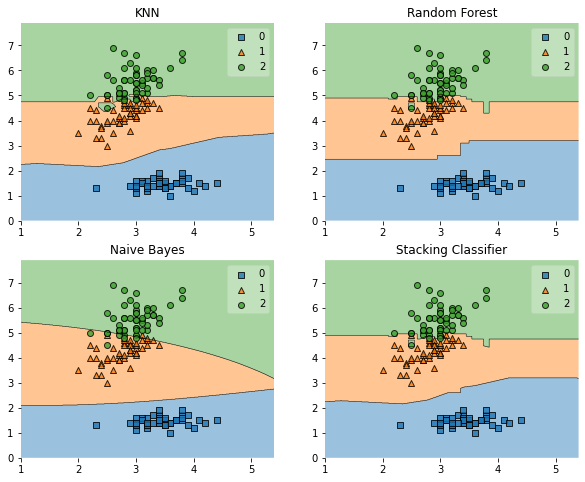

In [2]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions


# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target


clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)


clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)


plt.show()